# Modules

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import cmocean
from scipy.interpolate import griddata



# Plotting Functions 

In [2]:
font = {'family' : 'DejaVu Sans',
    'weight' : 'normal',
    'size'   : 14}

matplotlib.rc('font', **font)

# Code courtesy of Chris Williams, http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))   
      
def pcolorAutoScale( ax ,x, y , data, cmap, vMin=None, vMax=None):
    
    if (vMax == None):    
        vMax = np.max( data )
    if (vMin == None):
        vMin = np.min( data )

    return ax.pcolor(x, y, data, cmap=cmap, vmin=vMin, vmax=vMax, norm=MidpointNormalize(midpoint=0,vmin=vMin, vmax=vMax) )


def plotBathy( ax, x, y, z , stride=1):
    
    def getLength(s):
        sMax = np.max(s)
        sMin = np.min(s)
        sL = sMax - sMin 
        return sL 
    
    cmBathy = cmocean.cm.topo 
    cmBathyContour = cmocean.cm.matter

    maxLen = 12
    
    xL = getLength(x)
    yL = getLength(y) 

    cp = pcolorAutoScale(ax,x[::stride],y[::stride],z[::stride,::stride],cmBathy )
    
    if ( xL > yL ):
        cb = fig.colorbar(cp , ax=ax, orientation='horizontal')
    else:
        cb = fig.colorbar(cp , ax=ax, orientation='vertical')
        
    cb.set_label('Topology/Bathymetry (m)')

    ax.set_aspect('equal', 'box')
    
    CS = ax.contour(x , y, z, 10, cmap=cmBathyContour )
    plt.clabel(CS, inline=1, fontsize=14)
    
    ax.set_xlabel( "x (m)")    
    ax.set_ylabel( "y (m)")

# Topography/Bathymetry File Path and Grid Information

In [3]:
bathyFilePath = 'testBathy.txt'

# Origin point of grid
x0 = 0
y0 = 0

# Grid Resolution
dx = 0.5
dy = 0.5

# Maximum number of points to plot in a single direction 
maxLinearPlotPoints = 200

# Plotting Input Topography/Bathymetry

Grid Dimensions: nGlob=90, mGlob=120, stride=1
Plot Dimensions: nGlob=90, mGlob=120


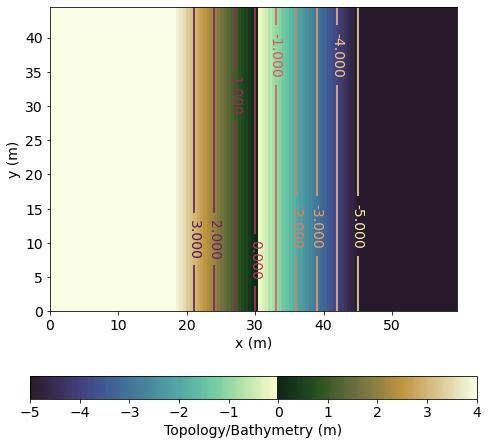

In [4]:
# Loading data
funwaveBathy = np.loadtxt(bathyFilePath) 

# Reversing FUNWAVE sign change, easier to work with
bathy = -funwaveBathy
[nGlob, mGlob] = funwaveBathy.shape

# Constructing equispaced grid  
x = np.arange(0,mGlob)*dx + x0
y = np.arange(0,nGlob)*dy + y0

# Computing stride based on max linear plot size
nMax = max(nGlob,mGlob)

stride = int(nMax/maxLinearPlotPoints)
if ( stride < 1 ): stride = 1
    
nGlobPlot = int( nGlob/stride )
mGlobPlot = int( mGlob/stride )

print( "Grid Dimensions: nGlob=%d, mGlob=%d, stride=%d" % (nGlob, mGlob, stride) )
print( "Plot Dimensions: nGlob=%d, mGlob=%d" % (nGlobPlot,mGlobPlot) )

# Plotting topography/bathymetry
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)


plotBathy( ax, x, y, bathy, stride )


# Rotation information

In [5]:
# Rotation angle in degrees 
rotation = 30

# Point to rotated grid about
xR0 = 0
yR0 = 0


# Rotating grid 

Text(0.5, 1.0, 'Rotated Grid')

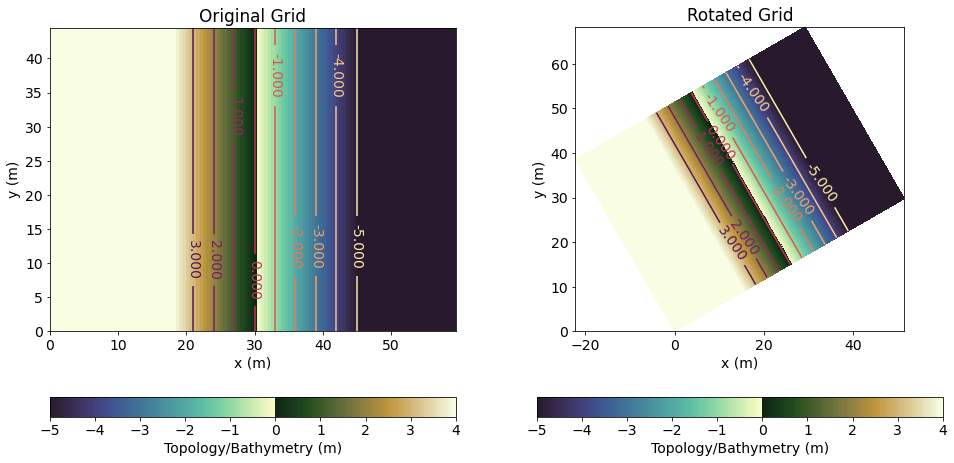

In [6]:
# Generating linear partition
x = np.arange(0,mGlob,1)*dx
y = np.arange(0,nGlob,1)*dy

# Generating 2D partitions
[X,Y] = np.meshgrid(x,y)

# Rotating grid
rotationRad = rotation*(np.pi/180)
U = xR0 + (X-xR0)*np.cos(rotationRad) - (Y-yR0)*np.sin(rotationRad)
V = yR0 + (X-xR0)*np.sin(rotationRad) + (Y-yR0)*np.cos(rotationRad)


# Creating bounding box and rotating
xMin = x.min(); xMax = x.max()
yMin = y.min(); yMax = y.max()
boxX = np.array([ xMin, xMin, xMax, xMax, xMin])
boxY = np.array([ yMin, yMax, yMax, yMin, yMin])
boxU = xR0 + (boxX-xR0)*np.cos(rotationRad) - (boxY-yR0)*np.sin(rotationRad)
boxV = yR0 + (boxX-xR0)*np.sin(rotationRad) + (boxY-yR0)*np.cos(rotationRad)

# Plotting bathy and rotated bathy
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16, 8)
plotBathy( axs[0], X, Y, bathy , stride=1)
axs[0].set_title('Original Grid')
plotBathy( axs[1], U, V, bathy , stride=1)
axs[1].set_title('Rotated Grid')


# Grid spacing for interpolated grid

In [7]:
dxI = 1
dyI = 1

interpolation_mode = 'nearest'


# Interpolating rotated grid onto equispace grid and extrapolating data beyond rotated grid domain boundries to maximize domain boundries 

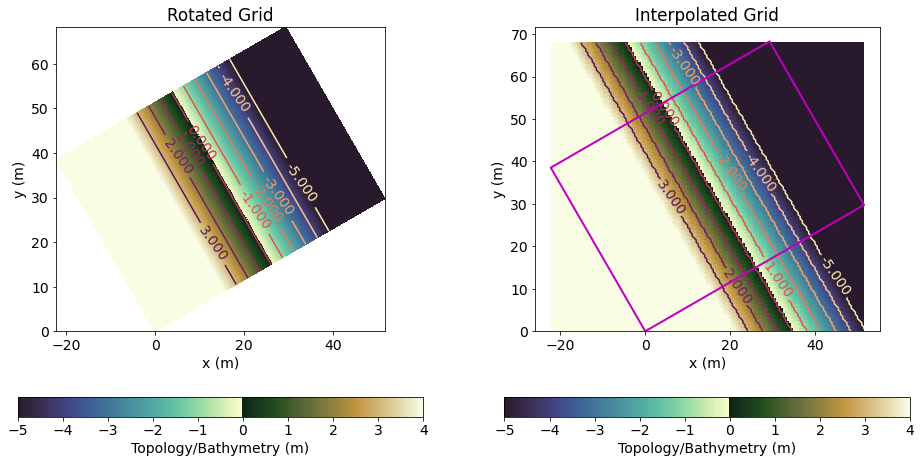

In [8]:

# Creating interpolation grid
uMin = U.min(); uMax = U.max()
vMin = V.min(); vMax = V.max()
uMin = np.round((uMin/dxI),decimals=0)*dxI
vMin = np.round((vMin/dyI),decimals=0)*dyI

uI = np.arange(uMin,uMax,dx)
vI = np.arange(vMin,vMax,dy)

UI,VI = np.meshgrid(uI,vI)


# Interpolating data onto new grid and extrapolating passed domain boundaries
nPts = mGlob*nGlob
pts = np.zeros( [nPts,2])

pts[:,0]=U.flatten()
pts[:,1]=V.flatten()
vals = bathy.flatten()


bathyI = griddata(pts, vals, (UI, VI), method=interpolation_mode)

if ( not interpolation_mode == 'nearest'):
    bathyITmp = griddata(pts, vals, (UI, VI), method='nearest')

    bathyI[ np.isnan(bathyI) ] = bathyITmp[ np.isnan(bathyI) ] 
    

fig, axs = plt.subplots(1,2)
fig.set_size_inches(16, 8)



plotBathy( axs[0], U, V, bathy , stride=1)
axs[0].set_title('Rotated Grid')
plotBathy( axs[1], UI, VI, bathyI , stride=1)
axs[1].set_title('Interpolated Grid')
axs[1].plot(boxU,boxV,color='m',linewidth=2)


# Cropped Interpolated Grid Limits

In [13]:
xCropMin = -10
xCropMax = 40

yCropMin = 10
yCropMax = 50

# Cropping Interpolated Grid

MGlob: 101
NGlob: 81
dx   : 1.000000
dy   : 1.000000
x0   : -10.000000
y0   : 10.000000


(10.0, 50.0)

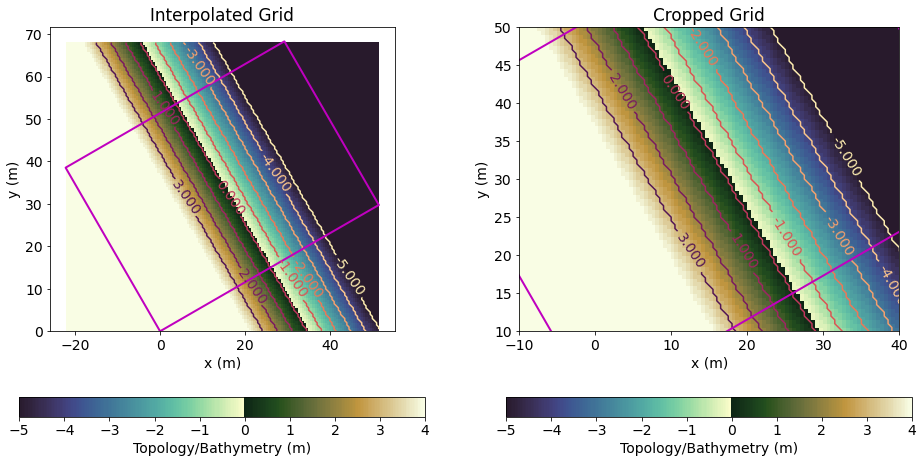

In [19]:
# Cropping Grid
xIdx = ( xCropMin <= uI) & (uI <= xCropMax)
yIdx = ( yCropMin <= vI) & (vI <= yCropMax)
xC = uI[xIdx]
yC = vI[yIdx]

bathyC = bathyI[:,xIdx]
bathyC = bathyC[yIdx,:]


# Print New Grid Info
print( "MGlob: %d" % len(xC) )
print( "NGlob: %d" % len(yC) )
print( "dx   : %f" % dxI )
print( "dy   : %f" % dyI )
print( "x0   : %f" % xC.min() )
print( "y0   : %f" % yC.min() )




# Plotting Grid
fig, axs = plt.subplots(1,2)
fig.set_size_inches(16, 8)

plotBathy( axs[0], UI, VI, bathyI , stride)
axs[0].set_title('Interpolated Grid')
axs[0].plot(boxU,boxV,color='m',linewidth=2)

plotBathy( axs[1], xC, yC, bathyC , stride)
axs[1].set_title('Cropped Grid')
axs[1].plot(boxU,boxV,color='m',linewidth=2)
axs[1].set_xlim([xCropMin,xCropMax])
axs[1].set_ylim([yCropMin,yCropMax])


# Saving Rotated and Cropped Grid

In [ ]:
outputFilePath = 'rotatedGrid.txt'

np.savetxt( outputFilePath, -bathyC)